In [1]:
import numpy as np
import matplotlib.pyplot as plt
import CosmoBolognaLib as cbl
from CosmoBolognaLib import DoubleVector as dv
from CosmoBolognaLib import DoubleVectorVector as dvv

import os 
from matplotlib import rc
from scipy.integrate import quad, romb
from scipy.interpolate import interp1d

rc('text', usetex=True)
rc('font', family='serif')
rc('font', size=14)

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

from multiprocessing import Pool, cpu_count
os.environ["OMP_NUM_THREADS"] = "1"
import emcee
from chainconsumer import ChainConsumer

eb_default_kwargs = {"ls" : "",
                     "barsabove" : False,
                     "ecolor" : "k",
                     "mec" : "k",
                     "elinewidth" : 1.2,
                     "mew" : 1.2,
                     "capsize" : 3}

In [2]:
import CosmoBolognaLib as cbl

cbl.SetDirs("/home/alfonso/CosmoBolognaLib/", cbl.fullpath("./"))

In [3]:
from loopfftlog import *

In [4]:
#Dictionary to fill missing part of the file name
 
snap_to_name = {"00026" : "halosAbove90",
                "00030" : "halosAbove80",
                "00037" : "halosAbove56",
                "00045" : "halosAbove48"}

truth = {"00026" : [2.4833, 1.0264, -0.8572, 2.0867, 7.4191],
         "00030" : [2.0209, -0.1183, -0.5516, 1.1307, 2.0627],
         "00037" : [1.7370, -0.3630, -0.3863, 0.7533, 3.7055],
         "00045" : [1.3679, -0.6209, -0.2283, 0.4114, 2.8042]
        }
snap_to_z = {"00026" : 4,
             "00030" : 3,
             "00037" : 2,
             "00045" : 1}

snap_list = ["00045", "00037", "00030", "00026"]

model_rad = np.linspace(1., 150, 200)

Dz = {"00045" : 0.63178,
      "00037" : 0.55868,
      "00030" : 0.48880,
      "00026" : 0.44589}

cosmology = cbl.Cosmology()

path = "../../gc-wp-nonlinear/linear_spectra_flagship/matter/high_res/"
pk_EH = np.genfromtxt(path+"EH_linear_spectra_flagship_high_res_matterpower_z0p0.dat", unpack=True)
pk_Lin = np.genfromtxt(path+"flagship_linear_cb_hr_matterpower_z0p0.dat", unpack=True)

kk = pk_EH[0]
pk_NW = np.array(cosmology.Pk_DM_NoWiggles_gaussian (kk, pk_Lin[1], pk_EH[1], 0.25, "gaussian_1d"))

interp_pk_NW = interp1d(kk, pk_NW, kind="cubic") 
interp_pk_Lin = interp1d(kk, pk_Lin[1], kind="cubic") 

kBAO = np.pi/110.
ks = 0.2
integrand = lambda q : interp_pk_NW(q) * (1 - cbl.j0(q / kBAO) + 2 * cbl.j2(q / kBAO))
    
sigma2 = quad(integrand, 1.e-6, ks, limit = 100, epsabs = 0, epsrel = 10**(-5))[0]/(6*np.pi**2)

In [5]:
def read_xi(snap, mod):
    root_dir = "../../gc-wp-nonlinear/multipoles_xi_flagship_snap/real_space/"
    file_name = "ksi_multipoles_REAL_Mock_mod%d_fun2_flagship_%s_%s_rmin_0.0_rmax_150.0_nr_30_nmu_200.txt"
    file_name = root_dir+file_name%(mod, snap, snap_to_name[snap])
    rad, xi0, xi2, xi4 = np.genfromtxt(file_name, unpack=True)
    len_xi = len(rad)
    file_name = root_dir + "dataset_mod%d_z%d_covariance.dat"%(mod, snap_to_z[snap])
    
    covariance = np.genfromtxt(file_name, unpack=True, usecols=2)
    
    len_cov = int(np.sqrt(len(covariance)))
    covariance = np.reshape(covariance, newshape=(len_cov, len_cov))[0:len_xi, 0:len_xi]
    
    return rad, xi0, covariance

In [6]:
class Model:
    
    def __init__(self, rad, snap):
        
        DD = Dz[snap]
        
        pk_matter = PkMatter(Nmax=512)
        pk_matter.set_tables()
        
        self.xi_matter = XiMatter(Nmax=256, bias=-0.2)
        self.xi_matter.set_tables()

        self.xi_bias = XiBias(Nmax=256, bias=-1.6)
        self.xi_bias.set_tables()
        
        table_pk_NW = np.array(pk_matter(interp1d(kk, DD**2*pk_NW, kind="cubic")))
        table_pk_Lin = np.array(pk_matter(interp1d(kk, DD**2*pk_Lin[1], kind="cubic")))

        damp = DD**2 * sigma2 * table_pk_NW[0]**2

        pk_W = table_pk_Lin[1] - table_pk_NW[1]
        pk_LO = table_pk_NW[1] + np.exp(-damp) * pk_W

        pk_NW_1L = table_pk_NW[2] + table_pk_NW[3]
        pk_Lin_1L = table_pk_Lin[2] + table_pk_Lin[3]

        pk_M = pk_LO + pk_NW_1L + np.exp(-damp) *\
                 (damp * pk_W + (pk_Lin_1L - pk_NW_1L))
        
        self.pk_LO = pk_LO
        self.pk_M = pk_M
        self.kk = table_pk_NW[0]
        self.interp_pk_M = interp1d(self.kk, self.pk_M, kind="cubic")
        self.interp_pk_LO = interp1d(self.kk, self.pk_LO, kind="cubic")
        self.xi = self.get_xi(rad)
        
    def get_xi (self, rad):
        return np.array([self.xi_matter(rad, self.interp_pk_M),\
            *self.xi_bias(rad, self.interp_pk_LO)])
        
    def __call__(self, b1, b2, bg2, bg3, c0):
        
        terms = self.get_terms(b1, b2, bg2, bg3, c0)

        return np.dot(terms, self.xi)  
    
    def get_terms(self, b1, b2, bg2, bg3, c0):
        
        return np.array([b1**2,\
                        b1*b2,\
                        b1*bg2,\
                        b1*bg3,\
                        b2**2,\
                        b2*bg2,\
                        bg2*bg2,\
                        -2*c0])
    
    def full(self, rad, b1, b2, bg2, bg3, c0):
        
        terms = self.get_terms(b1, b2, bg2, bg3, c0)
        
        return np.dot(terms, self.get_xi(rad))

In [7]:
rad = np.linspace(10, 200, 150)

In [8]:
import emcee

def lnlik (theta, data, model, icov):
    mod = model(*theta)
    diff = data-mod
    return -0.5 * np.dot(diff, np.dot(icov, diff))

def lnprior(theta):
    b1, b2, bg2, bg3, c0 = theta
    if (b1>1) & (b1<5) & (b2>-5) & (b2<5) & (bg2>-5) & (bg2<5) & (bg3>-5) & (bg3<5) & (c0>-100) & (c0<100):
        return 0
    return -np.inf

def lnprob(theta, data, model, icov):
    lnpr = lnprior(theta)
    if not np.isfinite(lnpr):
        return -np.inf
    return lnlik(theta, data, model, icov) + lnpr



In [9]:
ndim = 5
nwalkers = 100
chain_size = 10000

sampler = {}
for sn in ["00026", "00030", "00037", "00045"]:
    for rMin in [10, 20, 30, 40, 50]:
    
        pars = truth[sn]
        pos = pars + 1e-4 * np.random.randn(nwalkers, ndim)
        rad, xi0, covariance = read_xi(sn, 3)

        ww = np.where(rad>=rMin)[0]
        rad = rad[ww]
        xi0 = xi0[ww]
        covariance = covariance[ww[0]:,ww[0]:]
        inverse = np.linalg.inv(covariance)
         
        model = Model(rad, sn)

        sampler[(sn, rMin)] = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(xi0, model, inverse))
    
        sampler[(sn, rMin)].run_mcmc(pos, chain_size, progress=False);


In [10]:
figure, ax = plt.subplots(2, 2, figsize=(14, 14))

ax = ax.flatten()

thin=10
discard=5000

color=  ("#000080",
         "#BA55D3",
         "#FF7F50",
         "#3CB371")

for i in range(len(ax)):
    pars = truth[snap_list[i]]
    ax[i].set_title("Snap %s"%snap_list[i])
    rad, xi0, covariance = read_xi(snap_list[i], 3)
    
    min_y = 1.2*np.min(xi0*rad**2)
    max_y = 1.2*np.max(xi0*rad**2)
    rr=np.linspace(1, 150, 100)
    model = Model(rr, snap_list[i])
    std = np.sqrt(np.diagonal(covariance))
    ax[i].set_ylim(min_y, max_y)
    for j,rm in enumerate([10, 20, 30, 40]):
        chain = sampler[(snap_list[i], rm)].get_chain(flat=True, thin=thin, discard=discard)
        models = [model(*theta) for theta in chain]
        
        ax[i].plot(rr, (np.median(models, axis=0))*rr**2, ls="--", lw=3, color=color[j]) 
        ww = np.where(rr>rm)
        ax[i].plot(rr[ww], (np.median(models, axis=0))[ww]*rr[ww]**2, ls="-", lw=3,\
                   label=r"$r_{min} = %d \mathrm{Mpc} \, h^{-1}$"%rm, color=color[j]) 
    ax[i].errorbar(rad, xi0*rad**2, ms = 8, yerr = std*rad**2, zorder=1000,**eb_default_kwargs, fmt="o", color="k", label="Data")

    ax[i].grid(True, color="0.5", ls="--")
    ax[i].legend(loc="upper right", framealpha=1, edgecolor="k", fancybox=True)
    ax[i].set_xlabel(r"$r \, [ \mathrm{Mpc} \, h^{-1} \, ]$")
    ax[i].set_ylabel(r"$\mu_{1/2}\left[ \hat{\xi}(r) - \xi^m(r) \right] / \sigma$")
figure.tight_layout()
    

In [11]:
figure, ax = plt.subplots(2, 2, figsize=(16, 8))

ax = ax.flatten()

thin=10
discard=5000

color=  ("#000080",
         "#BA55D3",
         "#FF7F50",
         "#3CB371")

for i in range(len(ax)):
    pars = truth[snap_list[i]]
    ax[i].set_title("Snap %s"%snap_list[i])
    rad, xi0, covariance = read_xi(snap_list[i], 3)
    print(snap_list[i])
    model = Model(rad, snap_list[i])
        
    std = np.sqrt(np.diagonal(covariance))
    
    ax[i].set_ylim(-4, 4)
    
    ax[i].axhline(-1, ls="--", color="0.3", lw=2)
    ax[i].axhline(1, ls="--", color="0.3", lw=2)

    for j,rm in enumerate([10, 20, 30, 40]):
        chain = sampler[(snap_list[i], rm)].get_chain(flat=True, thin=thin, discard=discard)
        models = [xi0-model(*theta) for theta in chain]
        
        ax[i].plot(rad, (np.median(models, axis=0))/std, ls="--", lw=4, color=color[j]) 
        ww = np.where(rad>rm)
        ax[i].plot(rad[ww], (np.median(models, axis=0))[ww]/std[ww], ls="-", lw=4,\
                   label=r"$r_{min} = %d \mathrm{Mpc} \, h^{-1}$"%rm, color=color[j]) 
    #ax[i].plot(rad, xi0*rad**2, "ok") 
    #ax[i].plot(rad, np.median(models, axis=0)*rad**2) 

    ax[i].grid(True, color="0.5", ls="--")
    ax[i].legend(loc="upper right", framealpha=1, edgecolor="k", fancybox=True)
    ax[i].set_xlabel(r"$r \, [ \mathrm{Mpc} \, h^{-1} \, ]$")
    ax[i].set_ylabel(r"$\mu_{1/2}\left[ \hat{\xi}(r) - \xi^m(r) \right] / \sigma$")
figure.tight_layout()
    

00045
00037
00030
00026


In [12]:
names = [r"$b_1$", r"$b_2$", r"$b_{G2}$", r"$b_{\Gamma3}$", r"$c_0$"]

burn_in = 1500
thin = 10



def chain_plotter(sn):
    cc = ChainConsumer()
    
    rMin = [10, 20, 30, 40]
    chi2_red = []
    dof = []
    for rm in rMin:
        rad, xi0, covariance = read_xi(sn, 3)
        ww = np.where(rad>=rm)[0]
        chain = sampler[(sn, rm)].get_chain(flat=True, thin=thin, discard=burn_in)
        post = sampler[(sn, rm)].get_log_prob(flat=True, thin=thin, discard=burn_in)
        chi2_red.append(-2 * np.max(post))
        dof.append(len(rad[ww])-5)
        cc.add_chain(chain,\
                     name=r"$r_{min} = %g \mathrm{Mpc} h ^{-1}$"%rm,\
                     parameters=names,\
                     posterior=post,\
                     num_eff_data_points=len(rad[ww]),
                     num_free_params = 5)
    cc.configure(linewidths=2, colors=color, zorder=[1000, 500, 100, 0], shade=True)

    fig = cc.plotter.plot()
    
    fig = cc.plotter.plot_summary(extra_parameter_spacing=1.5, show_names=True)

    ax = fig.axes
    for i in range(6):
        ax[i].set_title("")

    for i in range(5):
        ax[19+i].set_xlabel(names[i])

    for i in range(4):
        ax[6*i].findobj()[0].set_color("k")
        ax[6*i].findobj()[0].set_fontsize(13)
        


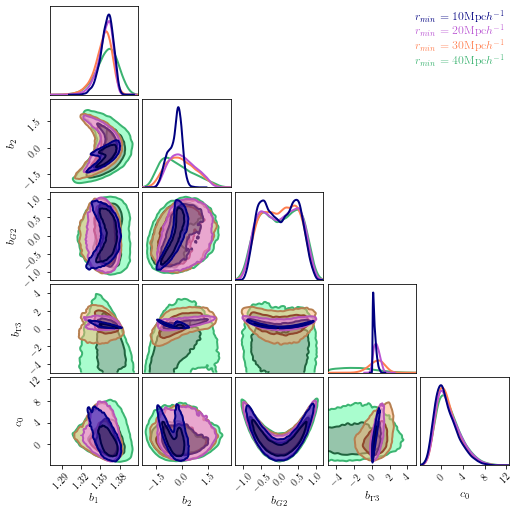

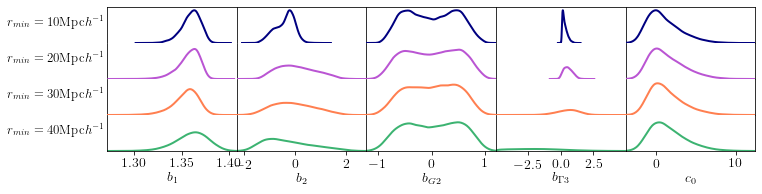

In [13]:
chain_plotter("00045")

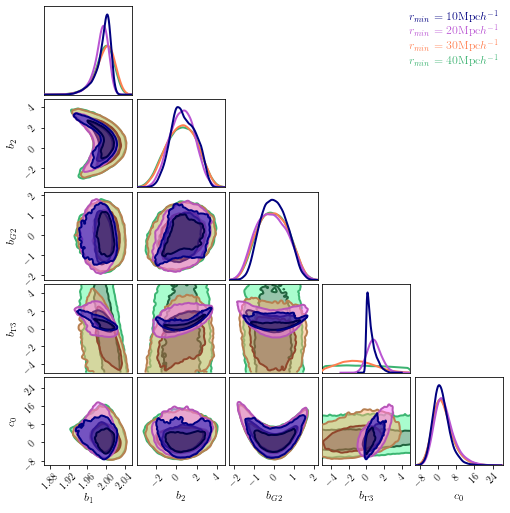

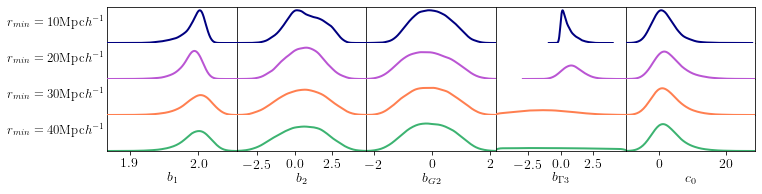

In [14]:
chain_plotter("00030")

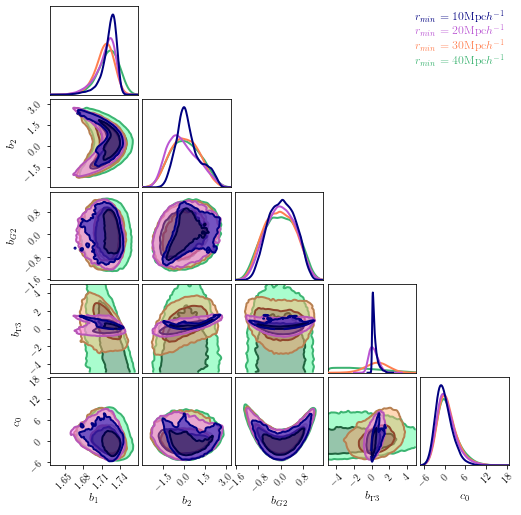

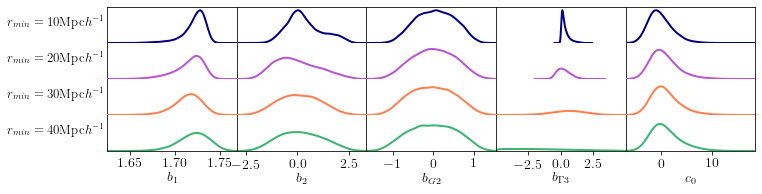

In [15]:
chain_plotter("00037")

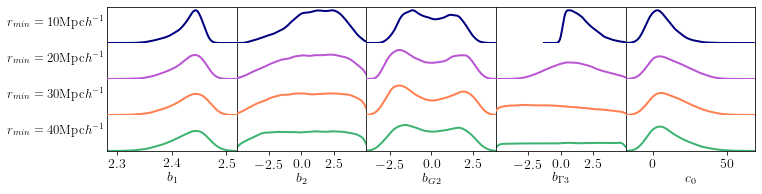

In [16]:
chain_plotter("00026")